# Sentiment Analysis with Deep Learning using BERT

## Exploratory Data Analysis and Preprocessing

In [14]:
import torch
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

import nltk 
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import BlanklineTokenizer
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
import string
import re
from nltk.tokenize import word_tokenize
import gensim
from keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer 
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['United', 'US Airways', 'American', 'Southwest', 'Delta', 'Virgin America']


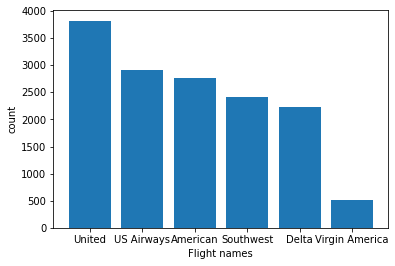

In [15]:

# load the dataset from csv
df = pd.read_csv('/home/Tweets.csv')
df.head()
ll = list(df.airline)
#print(ll)

#graph to see the distribution of data over flight names
import matplotlib.pyplot as plt
import collections

list_flight_names = collections.Counter(ll).most_common()

l1, l2 = [], []
for data in list_flight_names:
  l1.append(data[0])
  l2.append(data[1])


print(l1)
plt.bar(l1,l2)
#plt.plot(l1, l2)
plt.xlabel("Flight names")
plt.ylabel("count")
plt.show()



In [16]:
print(df.shape)
print(df.airline_sentiment.value_counts())
print("\n")
print("Total airline reviews: ", len(df))

(14640, 15)
negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


Total airline reviews:  14640


In [17]:
# get unique labels
possible_labels = df.airline_sentiment.unique()
print(possible_labels)

# give label a number
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

print(label_dict)

# add column name label with appropriate label value
df['label'] = df.airline_sentiment.replace(label_dict)
df.head()

['neutral' 'positive' 'negative']
{'neutral': 0, 'positive': 1, 'negative': 2}


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,label
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),0
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),1
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),0
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),2
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),2


In [18]:
# get the training and testing set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.30, 
                                                  random_state=17, 
                                                  stratify=df.label.values)

In [19]:
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
df.groupby(['airline_sentiment', 'label', 'data_type']).count()

tweet_id  ...  user_timezone
airline_sentiment label data_type            ...               
negative          2     train          6425  ...           4201
                        val            2753  ...           1807
neutral           0     train          2169  ...           1484
                        val             930  ...            644
positive          1     train          1654  ...           1169
                        val             709  ...            515

[6 rows x 14 columns]

In [20]:
!pip install transformers
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [21]:
# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [22]:
# load the data for testing (dataset2)
# dataset2 has nearly 7k reviews with 4 different flights
import pickle

final_test_data = []
final_test_labels = []
unitedAir = pickle.load(open("/home/unitedAir.pickle", "rb"))

#unitedAir = unitedAir[0]

#print(unitedAir)
for item in unitedAir['unitedAir']:
  if item[1] == 0:
    continue
  final_test_data.append("united airlines " + item[0])
  final_test_labels.append(item[1])

virginUS = pickle.load(open("/home/virginUS.pickle", "rb"))

for item in virginUS['virginUS']:
  if item[1] == 0:
    continue
  final_test_data.append("virginamerica " + item[0])
  final_test_labels.append(item[1])

southwest = pickle.load(open("/home/southwestAir.pickle", "rb"))

for item in southwest['southwestAir']:
  if item[1] == 0:
    continue
  final_test_data.append("southwestair " + item[0])
  final_test_labels.append(item[1])

americanAir = pickle.load(open("/home/americanAir.pickle", "rb"))


for item in americanAir['americanAir']:
  if item[0] == 0:
    continue
  final_test_data.append("americanair " + item[0])
  final_test_labels.append(item[1])

print(len(final_test_data), len(final_test_labels))

encode_data_test = tokenizer.batch_encode_plus(
    final_test_data, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)




Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


6833 6833


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [23]:
input_ids_test = encode_data_test['input_ids']
attention_masks_test = encode_data_test['attention_mask']
labels_test = torch.tensor(final_test_labels)


In [24]:
# preparing the train and validation data

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)




/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [26]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_trainX = TensorDataset(input_ids_train[:64], attention_masks_train[:64], labels_train[:64])
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)
print("Length of training data: ", len(dataset_train))
print("Length of validation data: ", len(dataset_val))
print("Length of testing data: ", len(dataset_test))

10248
4392
6833


## Setting up BERT Pretrained Model

In [27]:
from transformers import BertForSequenceClassification

In [28]:
# using the pre trained BERT model  
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Creating Data Loaders

In [29]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [30]:
# batch size 
batch_size = 32

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_trainX = DataLoader(dataset_trainX, 
                              sampler=RandomSampler(dataset_trainX), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

dataloader_test = DataLoader(dataset_test,
                             sampler=SequentialSampler(dataset_test),
                             batch_size=batch_size)

## Setting Up Optimiser and Scheduler

In [31]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [32]:
# optimizer
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

epochs = 25

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## Defining our Performance Metrics

In [34]:
import numpy as np

In [35]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import sklearn

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    #print(len(preds_flat), len(labels_flat))
    #return f1_score(labels, preds, average='weighted')
    return sklearn.metrics.f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return sklearn.metrics.accuracy_score(labels_flat, preds_flat)



In [36]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [37]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)
#import torch
torch.cuda.empty_cache()


cuda


In [38]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions = []
    true_vals = []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [39]:
# freezing the parameters as a paer of transfer learning
# freezed parameters: unfreezed parameters (80:20)

def freeze_model_layers(model, stop, start: int = 0):
    for i, param in enumerate(model.parameters()):
        if start <= i <= stop:
            param.requires_grad = False
        else:
            param.requires_grad = True  
    return

i = 0
for x, param in enumerate(model.parameters()):
  i += 1
print("Total params: ", i)
freeze_model_layers(model, 160)

Total params:  201


In [40]:
xx = []
yy = []
line = []

f1_score = []
accuracy_score = []


# training the model for epochs
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:
   
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        # prepare the input
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_trainX)
    val_f1 = f1_score_func(predictions, true_vals)
    val_acc =  accuracy_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    xx.append(loss_train_avg)
    yy.append(val_loss)
    f1_score.append(val_f1)
    accuracy_score.append(val_acc)
    line.append(epoch)






Epoch 1
Training loss: 0.6433543958860766
Validation loss: 0.6554962992668152
F1 Score (Weighted): 0.6437688273447677



Epoch 2
Training loss: 0.44767414077512946
Validation loss: 0.6196541488170624
F1 Score (Weighted): 0.6903812056737589



Epoch 3
Training loss: 0.4200064649463071
Validation loss: 0.5491907745599747
F1 Score (Weighted): 0.7305544772256729



Epoch 4
Training loss: 0.39539179860431456
Validation loss: 0.49116016924381256
F1 Score (Weighted): 0.7042735042735042



Epoch 5
Training loss: 0.3814454956264511
Validation loss: 0.4578546732664108
F1 Score (Weighted): 0.7770833333333333



Epoch 6
Training loss: 0.3598608899849969
Validation loss: 0.4274778962135315
F1 Score (Weighted): 0.8070786722904822



Epoch 7
Training loss: 0.34379363505639765
Validation loss: 0.3674554377794266
F1 Score (Weighted): 0.8074561403508771



Epoch 8
Training loss: 0.3335275528169124
Validation loss: 0.3383941575884819
F1 Score (Weighted): 0.8401809860619929



Epoch 9
Training loss: 0.31893880676907543
Validation loss: 0.30524158477783203
F1 Score (Weighted): 0.8522692814765984



Epoch 10
Training loss: 0.30748730823629744
Validation loss: 0.2798430919647217
F1 Score (Weighted): 0.8547252207088727



Epoch 11
Training loss: 0.29874665544272583
Validation loss: 0.25214527547359467
F1 Score (Weighted): 0.9052279565672423



Epoch 12
Training loss: 0.29162142896949317
Validation loss: 0.2081597000360489
F1 Score (Weighted): 0.9069177350427351



Epoch 13
Training loss: 0.2817413400266772
Validation loss: 0.21636098623275757
F1 Score (Weighted): 0.8845180573014875



Epoch 14
Training loss: 0.2668114898035831
Validation loss: 0.20475465804338455
F1 Score (Weighted): 0.9208527432712215



Epoch 15
Training loss: 0.26941764475400576
Validation loss: 0.189825639128685
F1 Score (Weighted): 0.9522799575821845



Epoch 16
Training loss: 0.26089136056439527
Validation loss: 0.1699700877070427
F1 Score (Weighted): 0.9527704906409529



Epoch 17
Training loss: 0.2522276173638778
Validation loss: 0.1803448349237442
F1 Score (Weighted): 0.9191815094241789



Epoch 18
Training loss: 0.24870408637408528
Validation loss: 0.17377589643001556
F1 Score (Weighted): 0.9361837855297157



Epoch 19
Training loss: 0.2500636209429146
Validation loss: 0.16146929562091827
F1 Score (Weighted): 0.9522799575821845



Epoch 20
Training loss: 0.24228733644539321
Validation loss: 0.15988008677959442
F1 Score (Weighted): 0.9522799575821845



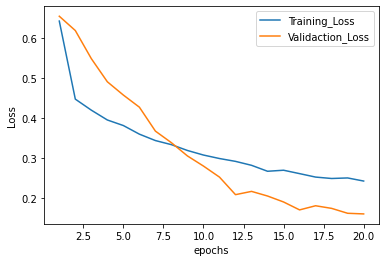

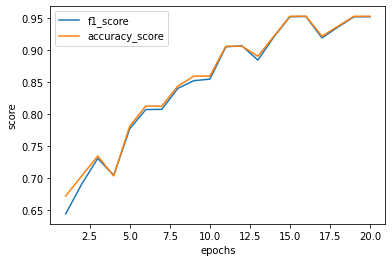

In [41]:
import matplotlib.pyplot as plt
plot1 = plt.figure(1)
plt.plot(line, xx, label = "Training_Loss")
plt.plot(line, yy, label = "Validaction_Loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plot2 = plt.figure(2)
plt.plot(line, f1_score, label = "f1_score")
plt.plot(line, accuracy_score, label = "accuracy_score")
plt.xlabel("epochs")
plt.ylabel("score")
plt.legend()
plt.show()

In [43]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [44]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
    return preds_flat
    

In [45]:
predictions = accuracy_per_class(predictions, true_vals)


Class: neutral
Accuracy: 618/930

Class: positive
Accuracy: 563/709

Class: negative
Accuracy: 2524/2753



In [46]:
from sklearn.metrics import confusion_matrix, roc_curve
print(confusion_matrix)
confusion_matrix = confusion_matrix(predictions, true_vals)
print(confusion_matrix)

import plotly.graph_objects as go
fig = go.Figure(data=[go.Table(
    header=dict(values=['Scores', 'Neutral', 'Positive', 'Negative', 'total'],
                line_color='darkslategray',
                fill_color='lightskyblue',
                align='left'),
    cells=dict(values=[['Neutral', 'Positive', 'Negative'],confusion_matrix[0], # 1st column
                       confusion_matrix[1], confusion_matrix[2], [929, 709, 2746]], # 2nd column
               line_color='darkslategray',
               fill_color='lightcyan',
               align='left'))
])

fig.update_layout(width=500, height=300)
fig.show()

<function confusion_matrix at 0x7f58de0aadd0>
[[ 618   85  163]
 [  92  563   66]
 [ 220   61 2524]]


In [47]:

# testing data
_, predictions, true_vals = evaluate(dataloader_test)
import pickle


# prediction for testing dataset(dataset2)
predictions = accuracy_per_class(predictions, true_vals)


Class: neutral
Accuracy: 2/91

Class: positive
Accuracy: 953/1747

Class: negative
Accuracy: 4979/4995



In [59]:
# f1 = open("/home/dataset2_pred.pickle", "wb")
# pickle.dump(predictions, f1)
# f2 = open("/home./dataset2_true.pickle", "wb")
# pickle.dump(true_vals, f2)

# evaluation on dataset2
print(len(final_test_data), len(final_test_labels), len(predictions), len(true_vals))

flight_name = "American Airlines"
import pandas as pd

cols = ["flight_name", "predicton", "true_label", "date", "review"]
dataset2_frame = pd.DataFrame(columns=cols)
flights_list = []
for text in final_test_data:
  flights_list.append(text.split(" ")[0])

print(flights_list)





6833 6833 6833 6833
['united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united', 'united',

In [60]:
df = pd.read_excel('/home/capstone_airline_reviews3.xlsx')
df.head()


,airline,overall,author,review_date,customer_review,aircraft,traveller_type,cabin,route,date_flown,seat_comfort,cabin_service,food_bev,entertainment,ground_service,value_for_money,recommended
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Turkish Airlines,7.0,Christopher Hackley,8th May 2019,âœ… Trip Verified | London to Izmir via Istanb...,NaN,Business,Economy Class,London to Izmir via Istanbul,2019-05-01 00:00:00,4.0,5.0,4.0,4.0,2.0,4.0,yes
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Turkish Airlines,2.0,Adriana Pisoi,7th May 2019,âœ… Trip Verified | Istanbul to Bucharest. We ...,NaN,Family Leisure,Economy Class,Istanbul to Bucharest,2019-05-01 00:00:00,4.0,1.0,1.0,1.0,1.0,1.0,no
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
dates = []


# print(df.airline.unique())



for data in df.review_date[df.airline =="United Airlines"]:
  dates.append(data)  

for data in df.review_date[df.airline =="virgin America"]:
  dates.append(data)  

for data in df.review_date[df.airline =="Southwest Airlines"]:
  dates.append(data)  

for data in df.review_date[df.airline =="American Airlines"]:
  dates.append(data)  


for i in range(len(dates), 6833):
  dates.append("NaN")
print(len(dates))

dataset2_frame["flight_name"] = flights_list
dataset2_frame["prediction"] = predictions
dataset2_frame["true_label"] = true_vals
dataset2_frame["date"] = dates
dataset2_frame["review"] = final_test_data

print(dataset2_frame.head())
pickle.dump(dataset2_frame,  open("/home/analysis_frame_pickle", "wb"))


6833
  flight_name  ... prediction
0      united  ...          2
1      united  ...          2
2      united  ...          2
3      united  ...          2
4      united  ...          2

[5 rows x 6 columns]


  flight_name  ... prediction
0      united  ...          2
1      united  ...          2
2      united  ...          2
3      united  ...          2
4      united  ...          2

[5 rows x 6 columns]
0            united
1            united
2            united
3            united
4            united
           ...     
6828    americanair
6829    americanair
6830    americanair
6831    americanair
6832    americanair
Name: flight_name, Length: 6833, dtype: object
['united airlines âœ… Trip Verified | Vancouver to Los Angeles via San Francisco. Worst airline ever. Iâ€™ll not fly UA again, it wasnâ€™t worth the money. We were on a family trip to celebrate my daughterâ€™s birthday. Our first flight were delayed by almost 2 hours. Because of that reason we lost our connection flight from SFO to LAX. Staff were rude, they booked us in separated seats (even my 5 yo daughter). Our second flight was also delayed by more than 1 hour. They ruined our mood and our trip. We weâ€™re exhausted afte

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Negative word cloud for United Airlines


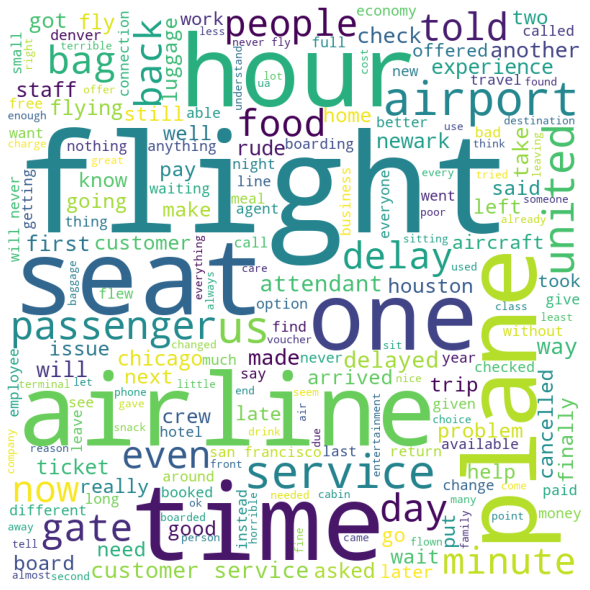

In [1]:
import pickle

frame = pickle.load(open("/home/analysis_frame_pickle", "rb"))
print(frame.head())


# create word cloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import collections

print(frame.flight_name)

reviews_AA = []
for data in frame.review[frame.prediction == 2]:
  reviews_AA.append(data)


all_reviews_AA = []
for data in frame.review[frame.flight_name == "united"]:
  if data in reviews_AA:
    all_reviews_AA.append(data)

print(all_reviews_AA)
comment_words = ''
stopwords = set(STOPWORDS)
for val in all_reviews_AA:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    
    xx = collections.Counter(tokens).most_common()
    new_tokens = []
    for t in xx:
      if t[1] == 1:
        new_tokens.append(t[0])
    #print(new_tokens[5:])
    comment_words += " ".join(new_tokens[5:])+" "

print(comment_words)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

print("Negative word cloud for United Airlines")
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

[2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

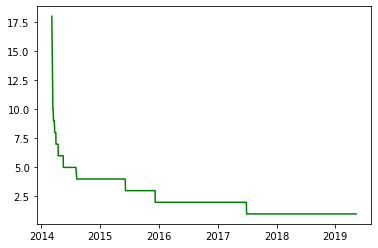

None


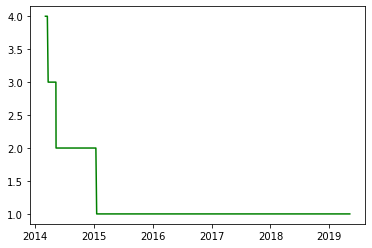

In [21]:
# plot over time for American Airline
# analysis on dataset2 on the bases of BERT prediction result

dates = []

for data in frame.date[frame.flight_name == "united"]:
  dates.append(data)

preds = []
for data in frame.prediction[frame.flight_name == "united"]:
  preds.append(data)

print(preds)
print(len(dates))

pos_date =  []
nag_date = []
for i in range(len(dates)):
  if preds[i] == 1:
    pos_date.append(dates[i])
  elif preds[i] == 2:
    nag_date.append(dates[i])

pos_date = collections.Counter(pos_date).most_common()
print(pos_date)

nag_date = collections.Counter(nag_date).most_common()
print(nag_date)


# plot the data
import datetime
#parse and convert it into datetime

month_dict = {"January": 1, "February": 1, "March": 3, "April": 4, "May":5, "June":6, "July":7, "August":8, "September": 9, "October": 10, "November": 11, "December": 12}

graph_dates = []
graph_count = []
for date in nag_date:
  new_date =   date[0].split(" ")
  #print(new_date)
  day = new_date[0].rstrip("th")
  day = day.rstrip("rd")
  day = day.rstrip("n")
  day = day.rstrip("s")
  dd = datetime.datetime(int(new_date[2]), month_dict[new_date[1]], int(day)) 
  graph_dates.append(dd)
  graph_count.append(date[1])
  

print(graph_dates.sort())


#plt.plot_date(graph_dates, graph_count)
fig, ax = plt.subplots()
ax.plot_date(graph_dates, graph_count, 'g')
plt.show()


graph_dates = []
graph_count = []
for date in pos_date:
  new_date =   date[0].split(" ")
  #print(new_date)
  day = new_date[0].rstrip("th")
  day = day.rstrip("rd")
  day = day.rstrip("n")
  day = day.rstrip("s")
  dd = datetime.datetime(int(new_date[2]), month_dict[new_date[1]], int(day)) 
  graph_dates.append(dd)
  graph_count.append(date[1])
  

print(graph_dates.sort())


#plt.plot_date(graph_dates, graph_count)
fig, ax = plt.subplots()
ax.plot_date(graph_dates, graph_count, 'g')
plt.show()



